In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import xgboost as xgb
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(42)
start_date = datetime(2019, 1, 1)
end_date = datetime(2023, 12, 31)
date_range = pd.date_range(start=start_date, end=end_date, freq='W')

stores = ['Store_A', 'Store_B', 'Store_C']
departments = ['Dept_1', 'Dept_2', 'Dept_3', 'Dept_4', 'Dept_5']

data = []
for date in date_range:
    for store in stores:
        for dept in departments:
            base_sales = np.random.normal(10000, 2000)
            seasonal_effect = 1000 * np.sin(2 * np.pi * date.dayofyear / 365)
            trend = (date - start_date).days * 0.5
            noise = np.random.normal(0, 500)
            
            weekly_sales = max(0, base_sales + seasonal_effect + trend + noise)
            
            is_holiday = date.weekday() == 6 and date.day <= 7
            
            data.append({
                'Date': date,
                'Store': store,
                'Dept': dept,
                'Weekly_Sales': weekly_sales,
                'IsHoliday': is_holiday,
                'Temperature': np.random.normal(70, 15),
                'Fuel_Price': np.random.normal(3.5, 0.5),
                'CPI': np.random.normal(210, 10),
                'Unemployment': np.random.normal(7.5, 1.5)
            })

df = pd.DataFrame(data)
df.head()

,Date,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment
0,2019-01-06,Store_A,Dept_1,11029.897853,True,79.715328,4.261515,207.658466,7.148795
1,2019-01-06,Store_A,Dept_2,13647.744693,True,62.957884,3.771280,205.365823,6.801405
2,2019-01-06,Store_A,Dept_3,9632.886118,True,44.126233,3.218856,199.871689,7.971371
3,2019-01-06,Store_A,Dept_4,7583.401696,True,91.984732,3.387112,210.675282,5.362878
4,2019-01-06,Store_A,Dept_5,9072.297543,True,52.735096,3.687849,203.993613,7.062459


In [3]:
print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"Missing values: {df.isnull().sum().sum()}")
df.info()

Dataset shape: (3915, 9)
Date range: 2019-01-06 00:00:00 to 2023-12-31 00:00:00
Missing values: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3915 entries, 0 to 3914
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          3915 non-null   datetime64[ns]
 1   Store         3915 non-null   object        
 2   Dept          3915 non-null   object        
 3   Weekly_Sales  3915 non-null   float64       
 4   IsHoliday     3915 non-null   bool          
 5   Temperature   3915 non-null   float64       
 6   Fuel_Price    3915 non-null   float64       
 7   CPI           3915 non-null   float64       
 8   Unemployment  3915 non-null   float64       
dtypes: bool(1), datetime64[ns](1), float64(5), object(2)
memory usage: 248.6+ KB


In [4]:
df = df.dropna()
df['Weekly_Sales'] = df['Weekly_Sales'].clip(lower=0)
df['Temperature'] = df['Temperature'].clip(lower=-20, upper=120)
df['Fuel_Price'] = df['Fuel_Price'].clip(lower=1, upper=6)

In [5]:
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week
df['Quarter'] = df['Date'].dt.quarter
df['DayOfYear'] = df['Date'].dt.dayofyear

le_store = LabelEncoder()
le_dept = LabelEncoder()
df['Store_encoded'] = le_store.fit_transform(df['Store'])
df['Dept_encoded'] = le_dept.fit_transform(df['Dept'])
df['IsHoliday_encoded'] = df['IsHoliday'].astype(int)

df_sorted = df.sort_values(['Store', 'Dept', 'Date'])
df_sorted['Sales_lag1'] = df_sorted.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(1)
df_sorted['Sales_lag2'] = df_sorted.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(2)
df_sorted['Sales_ma3'] = df_sorted.groupby(['Store', 'Dept'])['Weekly_Sales'].rolling(window=3).mean().values

df = df_sorted.dropna()

In [6]:
feature_cols = ['Store_encoded', 'Dept_encoded', 'Year', 'Month', 'Week', 'Quarter', 
                'DayOfYear', 'IsHoliday_encoded', 'Temperature', 'Fuel_Price', 
                'CPI', 'Unemployment', 'Sales_lag1', 'Sales_lag2', 'Sales_ma3']

X = df[feature_cols]
y = df['Weekly_Sales']

split_date = df['Date'].quantile(0.8)
train_mask = df['Date'] <= split_date
X_train, X_test = X[train_mask], X[~train_mask]
y_train, y_test = y[train_mask], y[~train_mask]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
models = {}
predictions = {}

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
models['Linear Regression'] = lr
predictions['Linear Regression'] = lr.predict(X_test_scaled)

rf = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
rf.fit(X_train, y_train)
models['Random Forest'] = rf
predictions['Random Forest'] = rf.predict(X_test)

xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42, max_depth=6)
xgb_model.fit(X_train, y_train)
models['XGBoost'] = xgb_model
predictions['XGBoost'] = xgb_model.predict(X_test)

In [8]:
results = {}
for name, pred in predictions.items():
    mse = mean_squared_error(y_test, pred)
    mae = mean_absolute_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    rmse = np.sqrt(mse)
    
    results[name] = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }
    
    print(f"{name}:")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE: {mae:.2f}")
    print(f"  R²: {r2:.3f}")
    print()

Linear Regression:
  RMSE: 0.00
  MAE: 0.00
  R²: 1.000

Random Forest:
  RMSE: 562.25
  MAE: 383.00
  R²: 0.938

XGBoost:
  RMSE: 441.30
  MAE: 310.74
  R²: 0.962



In [9]:
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 Most Important Features:")
print(feature_importance.head(10))

Top 10 Most Important Features:
         feature  importance
14     Sales_ma3    0.523155
13    Sales_lag2    0.228890
12    Sales_lag1    0.216976
11  Unemployment    0.005155
10           CPI    0.005054
9     Fuel_Price    0.004563
8    Temperature    0.004243
6      DayOfYear    0.002784
1   Dept_encoded    0.002200
4           Week    0.002140


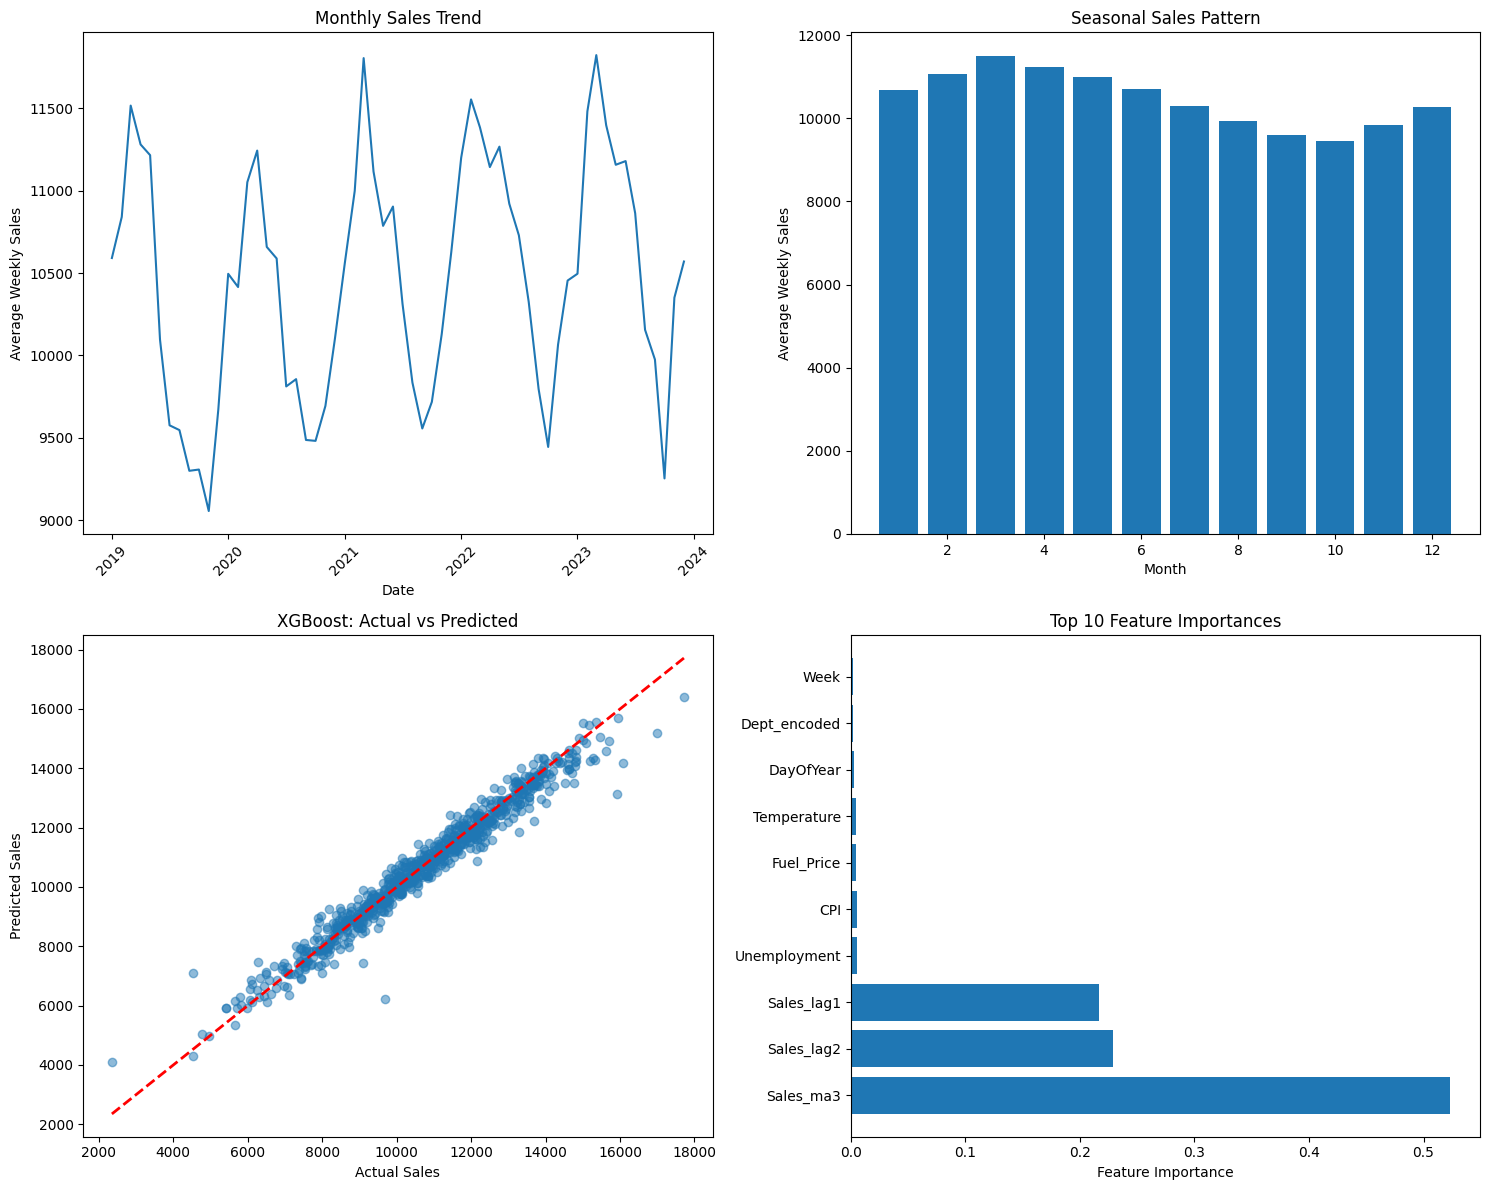

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

df_monthly = df.groupby(['Year', 'Month'])['Weekly_Sales'].mean().reset_index()
df_monthly['Date'] = pd.to_datetime(df_monthly[['Year', 'Month']].assign(day=1))
axes[0, 0].plot(df_monthly['Date'], df_monthly['Weekly_Sales'])
axes[0, 0].set_title('Monthly Sales Trend')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Average Weekly Sales')
for tick in axes[0, 0].get_xticklabels():
    tick.set_rotation(45)

seasonal_sales = df.groupby('Month')['Weekly_Sales'].mean()
axes[0, 1].bar(seasonal_sales.index, seasonal_sales.values)
axes[0, 1].set_title('Seasonal Sales Pattern')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Average Weekly Sales')

sample_size = min(1000, len(y_test))
sample_indices = np.random.choice(len(y_test), sample_size, replace=False)
y_test_sample = y_test.values[sample_indices] if hasattr(y_test, 'values') else y_test[sample_indices]
pred_sample = predictions['XGBoost'][sample_indices]
axes[1, 0].scatter(y_test_sample, pred_sample, alpha=0.5)
min_val = min(y_test_sample.min(), pred_sample.min())
max_val = max(y_test_sample.max(), pred_sample.max())
axes[1, 0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
axes[1, 0].set_xlabel('Actual Sales')
axes[1, 0].set_ylabel('Predicted Sales')
axes[1, 0].set_title('XGBoost: Actual vs Predicted')

feature_importance_top = feature_importance.head(10)
axes[1, 1].barh(range(len(feature_importance_top)), feature_importance_top['importance'])
axes[1, 1].set_yticks(range(len(feature_importance_top)))
axes[1, 1].set_yticklabels(feature_importance_top['feature'])
axes[1, 1].set_xlabel('Feature Importance')
axes[1, 1].set_title('Top 10 Feature Importances')

plt.tight_layout()
plt.show()

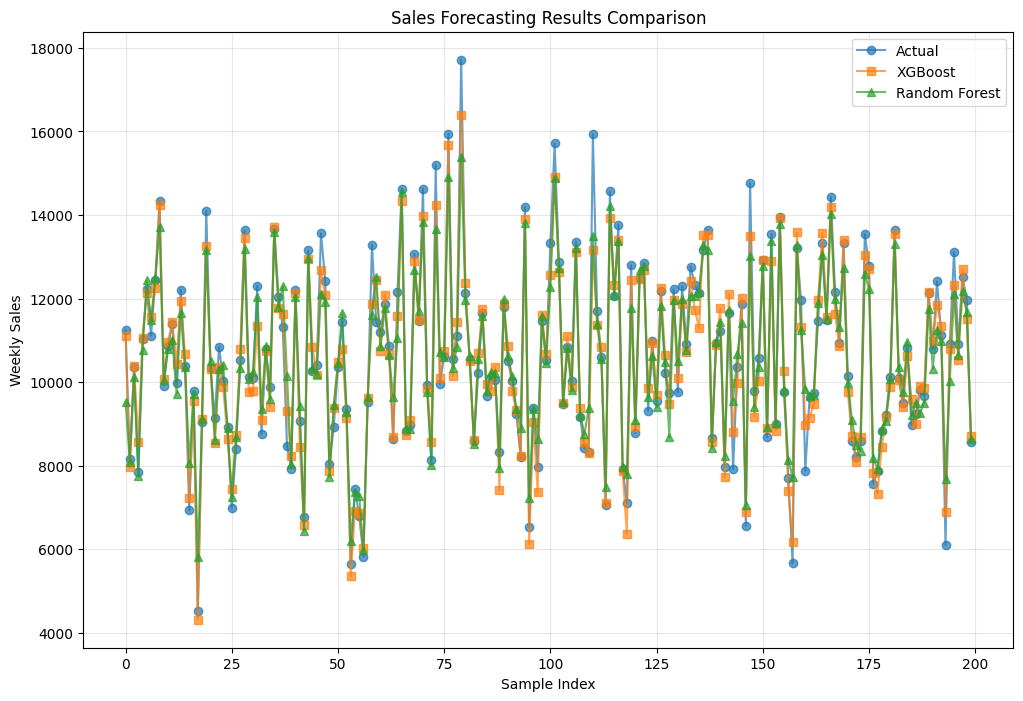

In [11]:
plt.figure(figsize=(12, 8))
sample_size = min(200, len(y_test))
sample_indices = np.random.choice(len(y_test), sample_size, replace=False)
x_axis = range(sample_size)

plt.plot(x_axis, y_test.iloc[sample_indices], 'o-', label='Actual', alpha=0.7)
plt.plot(x_axis, predictions['XGBoost'][sample_indices], 's-', label='XGBoost', alpha=0.7)
plt.plot(x_axis, predictions['Random Forest'][sample_indices], '^-', label='Random Forest', alpha=0.7)

plt.xlabel('Sample Index')
plt.ylabel('Weekly Sales')
plt.title('Sales Forecasting Results Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()